# Quiz Builder
This simple script helps teachers build quizzes and answer keys.  It can generate questions from a variety of sources including:
* Wikipedia Articles
* Local PDFs and assigned readings
* Web Articles


In [ ]:
# Install dependencies 
%pip install anthropic wikipedia reportlab pypdf abc

In [111]:
# Helper function for extracting content between XML tags
import re
def get_content_between_tags(tag, input_text):
    matches = re.findall(f"<{tag}>(.*?)</{tag}>", input_text, re.DOTALL)
    return matches[0]


## The Prompt

This base prompt expects to be passed a number of questions, as well as a chunk of background information (the text from an online article, wikipedia page, or local PDF)

In [128]:
BASE_PROMPT = """
  You are an expert at creating multiple choice questions. 
  I want you to create me a set of {num_questions} multiple choice questions on a particular topic. 

  Follow these guidelines:
  - Each question should have 4 answers, only 1 of which is correct.
  - The incorrect answers should be plausible enough to challenge people who do not know the material
  - The questions should not exclusively test memory, but also the ability to apply and synethsize informtion 
  - Avoid pure trivia.  Don't generate questions soley focused on dates or specific numbers.
  - The length and formatting of the answers should be relatively consistent.

  To help you draft the questions, I've provided you with relevant background information inside of <topic_background_information> tags.
  All the questions you generate should be answerable using the background information.  Do not write any questions that require outside knowledge.
  For all of the questions you create, gather any relevant quotes from the topic background information that prove the correct answer and put them inside of <relevant_quotes> tags

  Write the multiple choice questions using JSON inside of <questions></questions> tags. 

  The format and quality of your questions should follow the pattern seen in the <example> tags.  The topic for this example response is 'The Wars Of The Roses'

  <example>
  <relevant_quotes>
  * The Wars of the Roses (1455–1487) was a series of civil wars fought over control of the English throne between supporters of two rival cadet branches of the royal House of Plantagenet: Lancaster and York.
  * Key events included the First Battle of St Albans in 1455, Storming of the Bastille in 1460, and the Battle of Bosworth Field in 1485.
  * Major figures included Richard, Duke of York, Henry VI of England, Edward IV of England, Richard III of England, and Henry VII of England.
  </relevant_quotes>

  <questions>
  {{
    "questions": [
      {{
        "question": "What were the two rival houses involved in the Wars of the Roses?",
        "options": ["a) Lancaster and Tudor", "b) Plantagenet and Tudor", "c) Lancaster and York", "d) York and Windsor"],
        "correct_answer": 2
      }},
      {{
        "question": "Which battle in 1471 saw the death of Richard Neville, the Earl of Warwick?",
        "options": ["a) Battle of Barnet", "b) Battle of Tewkesbury", "c) Battle of Towton", "d) Battle of Bosworth Field"],
        "correct_answer": 0
      }},
      {{
        "question": "Who became the first Tudor king after defeating Richard III at the Battle of Bosworth in 1485?",
        "options": ["a) Henry IV", "b) Edward V", "c) Richard II", "d) Henry VII"],
        "correct_answer": 3
      }},
    ]
  }}
  </questions>
  </example>
 
  Use this background information to help craft the questions:

  <topic_background_information>
  {background_info}
  </topic_background_information>
  
  In your questions, do not reference the background material specifically with terms like 'the passage' or 'this passage'.
  Instead, use this provided <topic_name>{topic}</topic_name>
  You can assume students reading these questions will be familiar with the background information 

  """

## Data Sources

Defines a group of possible data sources
* `WikipediaDataSource` - loads a wikipedia page's content
* `PDFDataSource` - loads a local PDF file (like Machiavelli's The Prince)
* `WebArticleDataSource` - loads the article content from a webpage (very brittle borderline terrible scraping logic!)

This pattern would support any number of additional data sources like:
* `TextBookDataSource`
* `YoutubeVideoDataSource`
* etc. 

In [113]:
from abc import ABC, abstractmethod
import wikipedia
from pypdf import PdfReader
import requests
from bs4 import BeautifulSoup

# Abstract DataSource class
class DataSource(ABC):
    @abstractmethod
    def load_data(self, input):
        pass

# Wikipedia Data Source
class WikipediaDataSource(DataSource):
     def load_data(self, query, n_search_results_to_use=1):
        wiki_pages = wikipedia.search(query)
        results = []
        for page_name in wiki_pages:
            if len(results) >= n_search_results_to_use:
                break
            try:
                page = wikipedia.page(page_name)
            except wikipedia.exceptions.DisambiguationError as e:
                continue
            except wikipedia.exceptions.PageError as e:
                continue
            content = page.content
            title = page.title
            results.append({"title": title, "content": content})
        return results

# PDF data source
class PDFDataSource(DataSource):
    def load_data(self, file_name):
        reader = PdfReader(file_name)
        text = ''.join([page.extract_text() for page in reader.pages])
        return text

# Loads content from a URL (very brittle implementation)
class WebArticleDataSource(DataSource):
    def load_data(self, url):
        response = requests.get(url)
        if response.status_code != 200:
            return "Could not retrieve the article."

        soup = BeautifulSoup(response.content, 'html.parser')

        # Very generic (and terrible) approach to look for <p> tags from a given webpage source
        # A fancier implementation would send the page contents to Claude and as it to extract the important article content
        article_text = ' '.join([p.get_text() for p in soup.find_all('p')])
        return article_text




## Question Generation
Currently I only have a single Question Generation class, `MCQuestionGenerator` which generates a set of multiple choice questions based off a provided chunck of reading/background info.  

I designed the script to work with potential future question generators like:
* `TrueFalseQuestionGenerator`
* `FreeResponseQuestionGenerator` 

In [129]:
import json

class MCQuestionGenerator:
    def __init__(self, client):
        self.client = client
    
    def get_completion(self, prompt):
        reply = self.client.messages.create(
            model="claude-2.1",
            max_tokens=3000,
            messages=[{"role": "user", "content": prompt}]
        )
        return reply.content[0].text
    
    def generate_questions(self, context, topic, num_questions=5):
        prompt = BASE_PROMPT.format(num_questions=num_questions, background_info=context, topic=topic)
        claude_response = self.get_completion(prompt)
        questions_string = get_content_between_tags("questions", claude_response)
        json_questions = json.loads(questions_string)
        return json_questions["questions"]

## PDF Generation

This `PDFGenerator` class takes a series of questions, a quiz title, and a filename.  It spits out a PDF version of the quiz, along with an optional answer key which has the answers bolded.

In [116]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet

class PDFGenerator:
    def __init__(self):
        self.styles = getSampleStyleSheet()

    def generate_quiz(self, questions, title, filename, include_answer_key=True):
        doc = SimpleDocTemplate(f"{filename}.pdf")
        self._add_content_to_pdf(doc, questions, title)
        if include_answer_key:
            self.generate_answer_key_pdf(questions, title, filename)

    def generate_answer_key_pdf(self, questions, title, filename):
        doc = SimpleDocTemplate(f"{filename}_answers.pdf")
        self._add_content_to_pdf(doc, questions, f"{title} - Answer Key", include_answers=True)

    def _add_content_to_pdf(self, doc, questions, title, include_answers=False):
        flowables = [Paragraph(title, self.styles['Title']), Spacer(1, 12)]

        for i, question in enumerate(questions):
            # Question text
            flowables.append(Paragraph(f"{i + 1}. {question['question']}", self.styles['Normal']))
            flowables.append(Spacer(1, 12))

            # Options - marking the correct answer if include_answers is True
            for idx, option in enumerate(question['options']):
                if include_answers and idx == question['correct_answer']:
                    option_text = f"<b>{option}</b>"
                else:
                    option_text = option
                flowables.append(Paragraph(option_text, self.styles['Normal']))
                flowables.append(Spacer(1, 6))
            
            # Space after each question
            flowables.append(Spacer(1, 12))

        doc.build(flowables)



## Quiz Generation

This is the easy part! This quiz generator doesn't really do a whole lot. It only has two methods:
* `add_source_and_generate_questions` 
    * takes a data source and calls its particular `load_data` method
    * passes the returned data chunk to the question generator
    * stores the resulting questions in a list
* `generate_quiz` 
    * Calls the `generate_quiz` method on whatever type of `exporter` is configured
    
The class is written to eventually support other non-PDF exporters.  Maybe we want the quiz to be exported as HTML or some specific format required for a 3rd party quiz website?

The class is also written to support other types of question generation, but currently we only have our Multiple Choice Question Generator.

In [131]:
class QuizGenerator:
    def __init__(self, title, question_generator, export_generator):
        self.title = title
        self.question_generator = question_generator
        self.exporter = export_generator
        self.questions = []

    def add_source_and_generate_questions(self, data_source, source_input, topic, num_questions):
        data = data_source.load_data(source_input)
        questions = self.question_generator.generate_questions(data, topic=topic, num_questions=num_questions)
        self.questions.extend(questions)

    def generate_quiz(self, filename, include_answer_key=True):
        self.exporter.generate_quiz(
            questions=self.questions, 
            title=self.title, 
            filename=filename, 
            include_answer_key=include_answer_key
        )


## Putting It All Together!
To build our first quiz, let's pretend we are an AP European History teacher.
For this week's homework, we assigned students the following readings:
* Excerpts from Machiavelli's The Prince
* The Treaty of Westphalia (hosted web article)
* The Wikipedia Page on Martin Luther - realistically this would be a chunk of a textbook, not a wikipedia page

The following code creates a 12 question quiz based on those 3 readings and turns them into a PDF quiz and answer_key.

In [136]:
from anthropic import Anthropic
client = Anthropic()

mc_question_generator = MCQuestionGenerator(client)

# Create Our quiz
quiz = QuizGenerator(
    title="European History Quiz", 
    question_generator=mc_question_generator, 
    export_generator=PDFGenerator()
)

# Add 5 questions from the local PDF file containing excerpts from Machiavelli's The Prince
quiz.add_source_and_generate_questions(
    data_source=PDFDataSource(), 
    source_input="Readings/the-prince.pdf", 
    topic="Machiavelli's The Prince", 
    num_questions=5
)
# Add 3 questions from the Martin Luther Wikipdia Page
quiz.add_source_and_generate_questions(
    data_source=WikipediaDataSource(), 
    source_input="Martin Luther", 
    topic="Martin Luther And The 95 Theses", 
    num_questions=3
)
# Add 4 questions from a webpage containing The Treaty Of Westphalia
quiz.add_source_and_generate_questions(
    data_source=WebArticleDataSource(), 
    source_input="https://archive.schillerinstitute.com/strategic/treaty_of_westphalia.html", 
    topic="The Treaty Of Westphalia", 
    num_questions=4
)

# export to PDF (or whatever export source you have configured)
quiz.generate_quiz("ap_euro_quiz_week_1")


## Check Out The Results
If you don't want to run the code yourself, check out the screenshot below of the 2 output PDF's generated by the above code.  You can also view both PDF's in this repo.

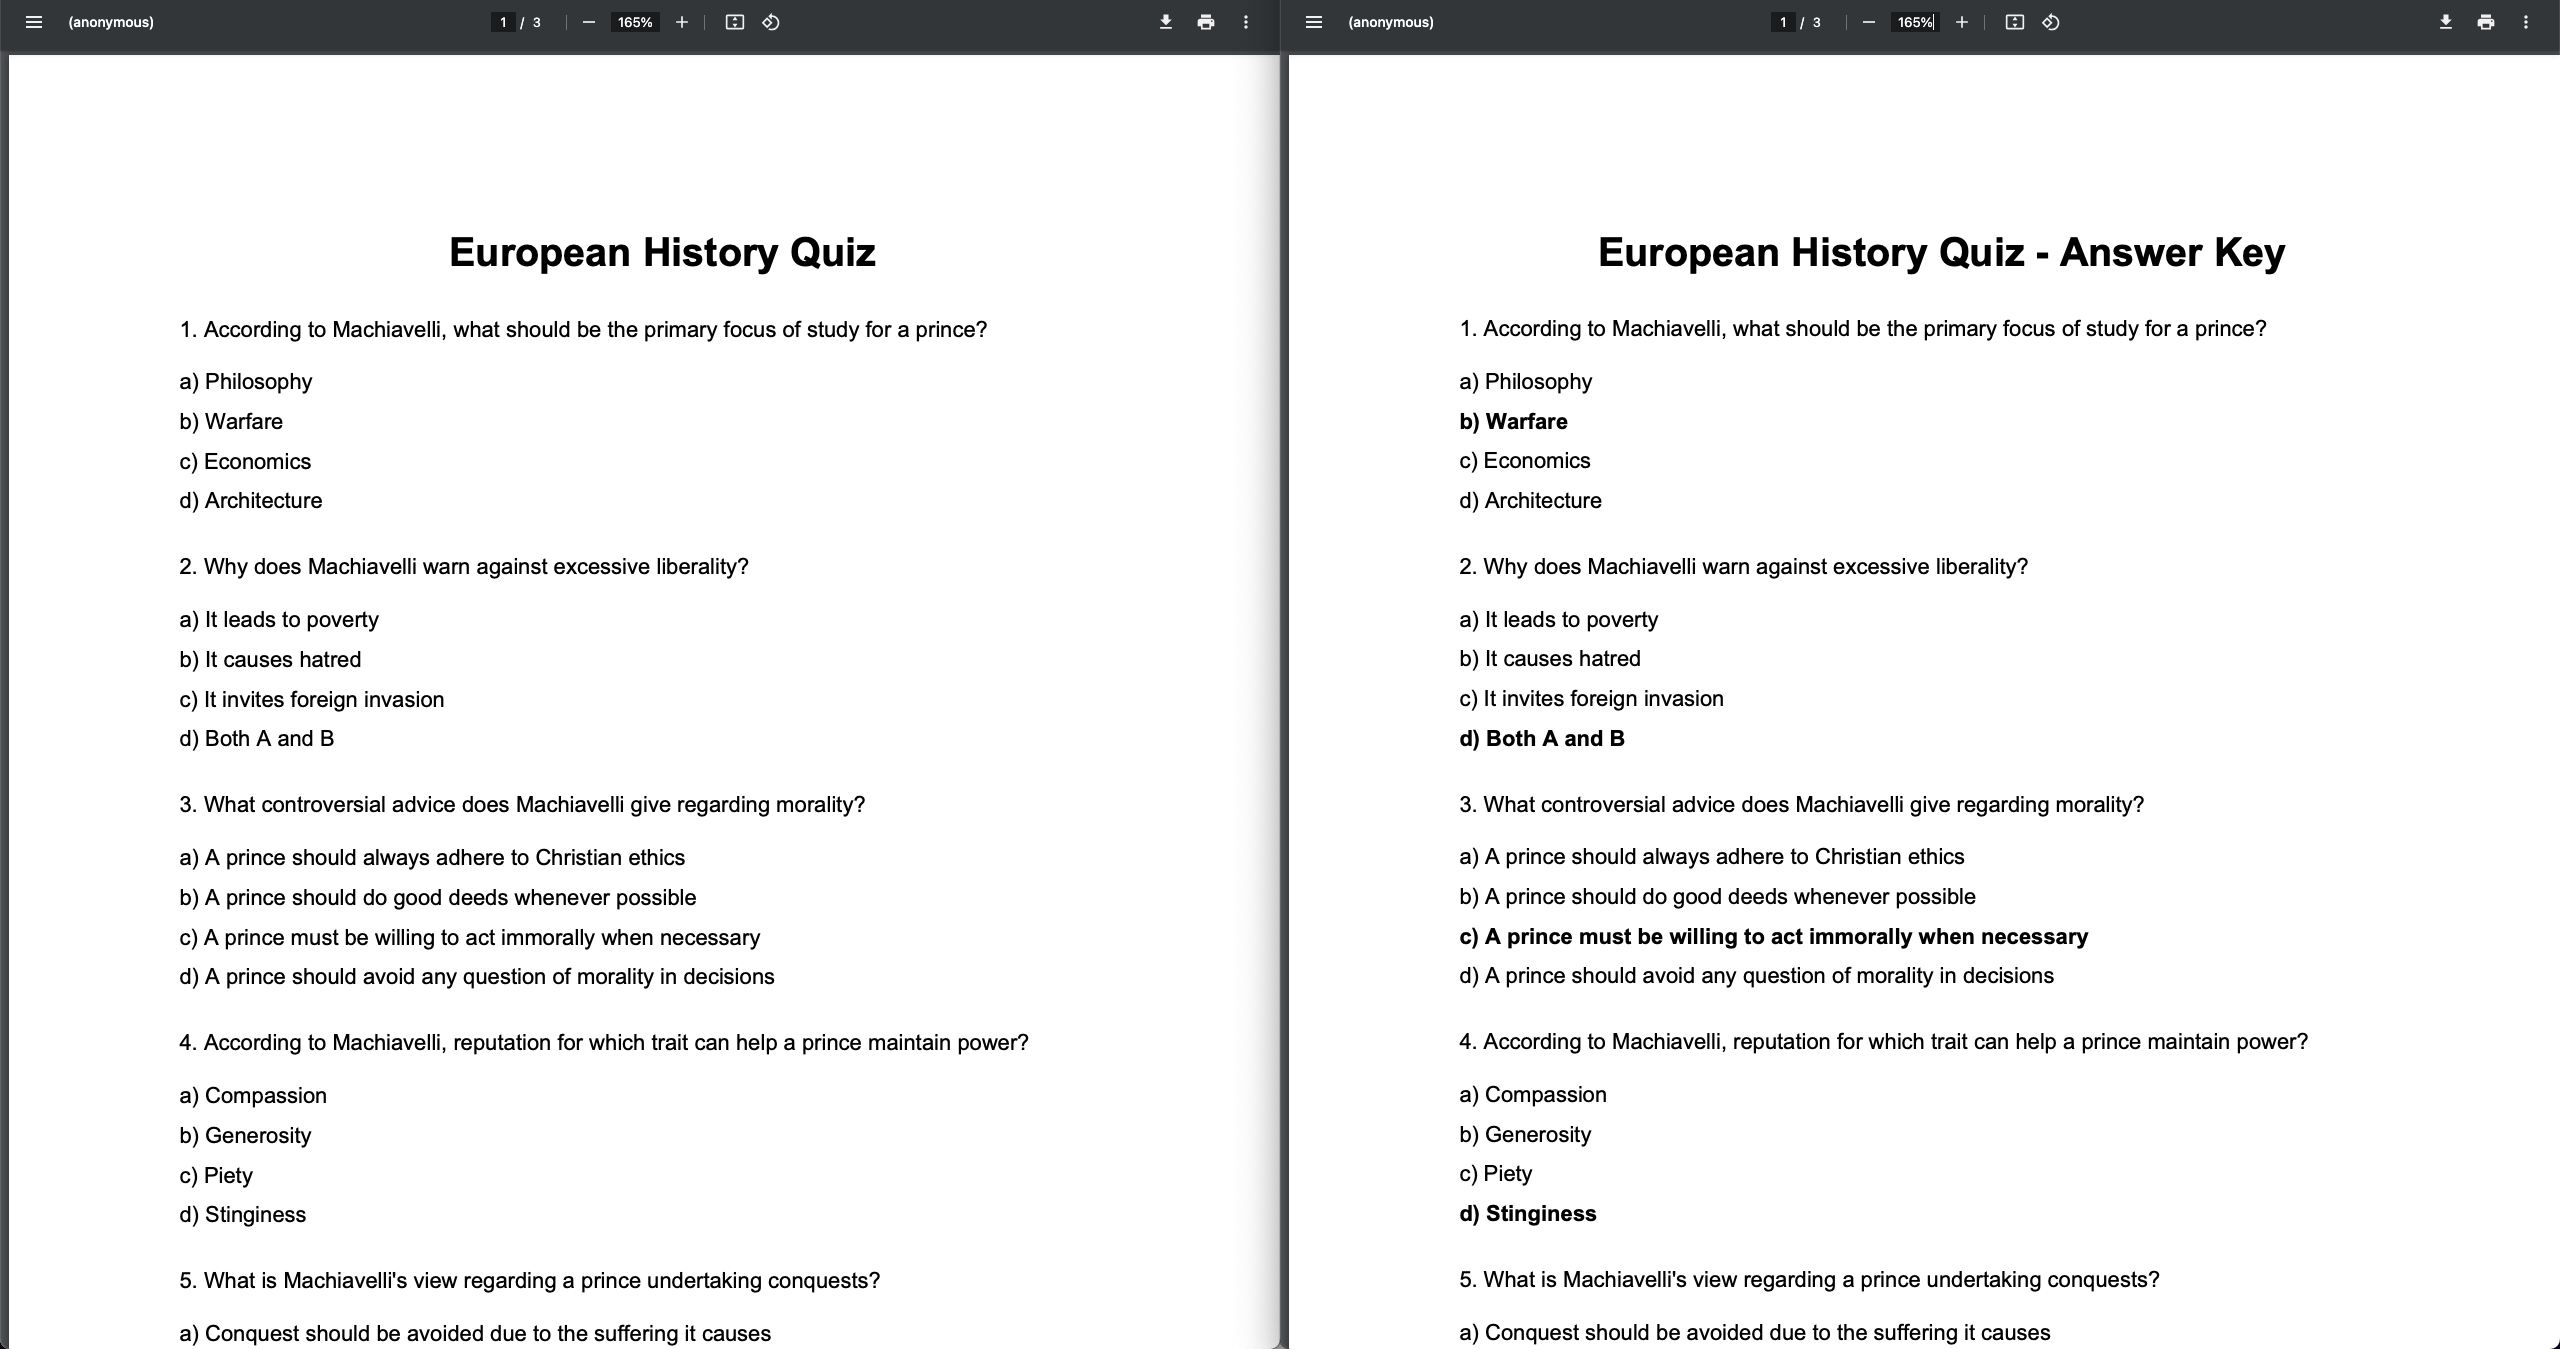

In [138]:
from IPython.display import Image

fig = Image(filename=('./quiz_screenshot.png'))
fig

## Let's Try Biology!
The example below creates a quiz based on excerpts from an AP Biology textbook, an article on Gregor Mendel, and the Wikipedia page on Natural Selection.  Check out the screenshot below or view the actual quizzes in the `GeneratedQuizzes/` folder

In [144]:
# Create Our quiz
bio_quiz = QuizGenerator(
    title="Biology Quiz", 
    question_generator=mc_question_generator, 
    export_generator=PDFGenerator()
)

bio_quiz.add_source_and_generate_questions(
    data_source=PDFDataSource(), 
    source_input="Readings/mitochondria.pdf", 
    topic="Mitochrondria", 
    num_questions=5
)

bio_quiz.add_source_and_generate_questions(
    data_source=WikipediaDataSource(), 
    source_input="Natural Selection", 
    topic="Natural Selection", 
    num_questions=4
)
bio_quiz.add_source_and_generate_questions(
    data_source=WebArticleDataSource(), 
    source_input="https://www.newscientist.com/people/gregor-mendel/", 
    topic="Gregor Mendel", 
    num_questions=4
)

# export to PDF (or whatever export source you have configured)
bio_quiz.generate_quiz("biology_quiz")

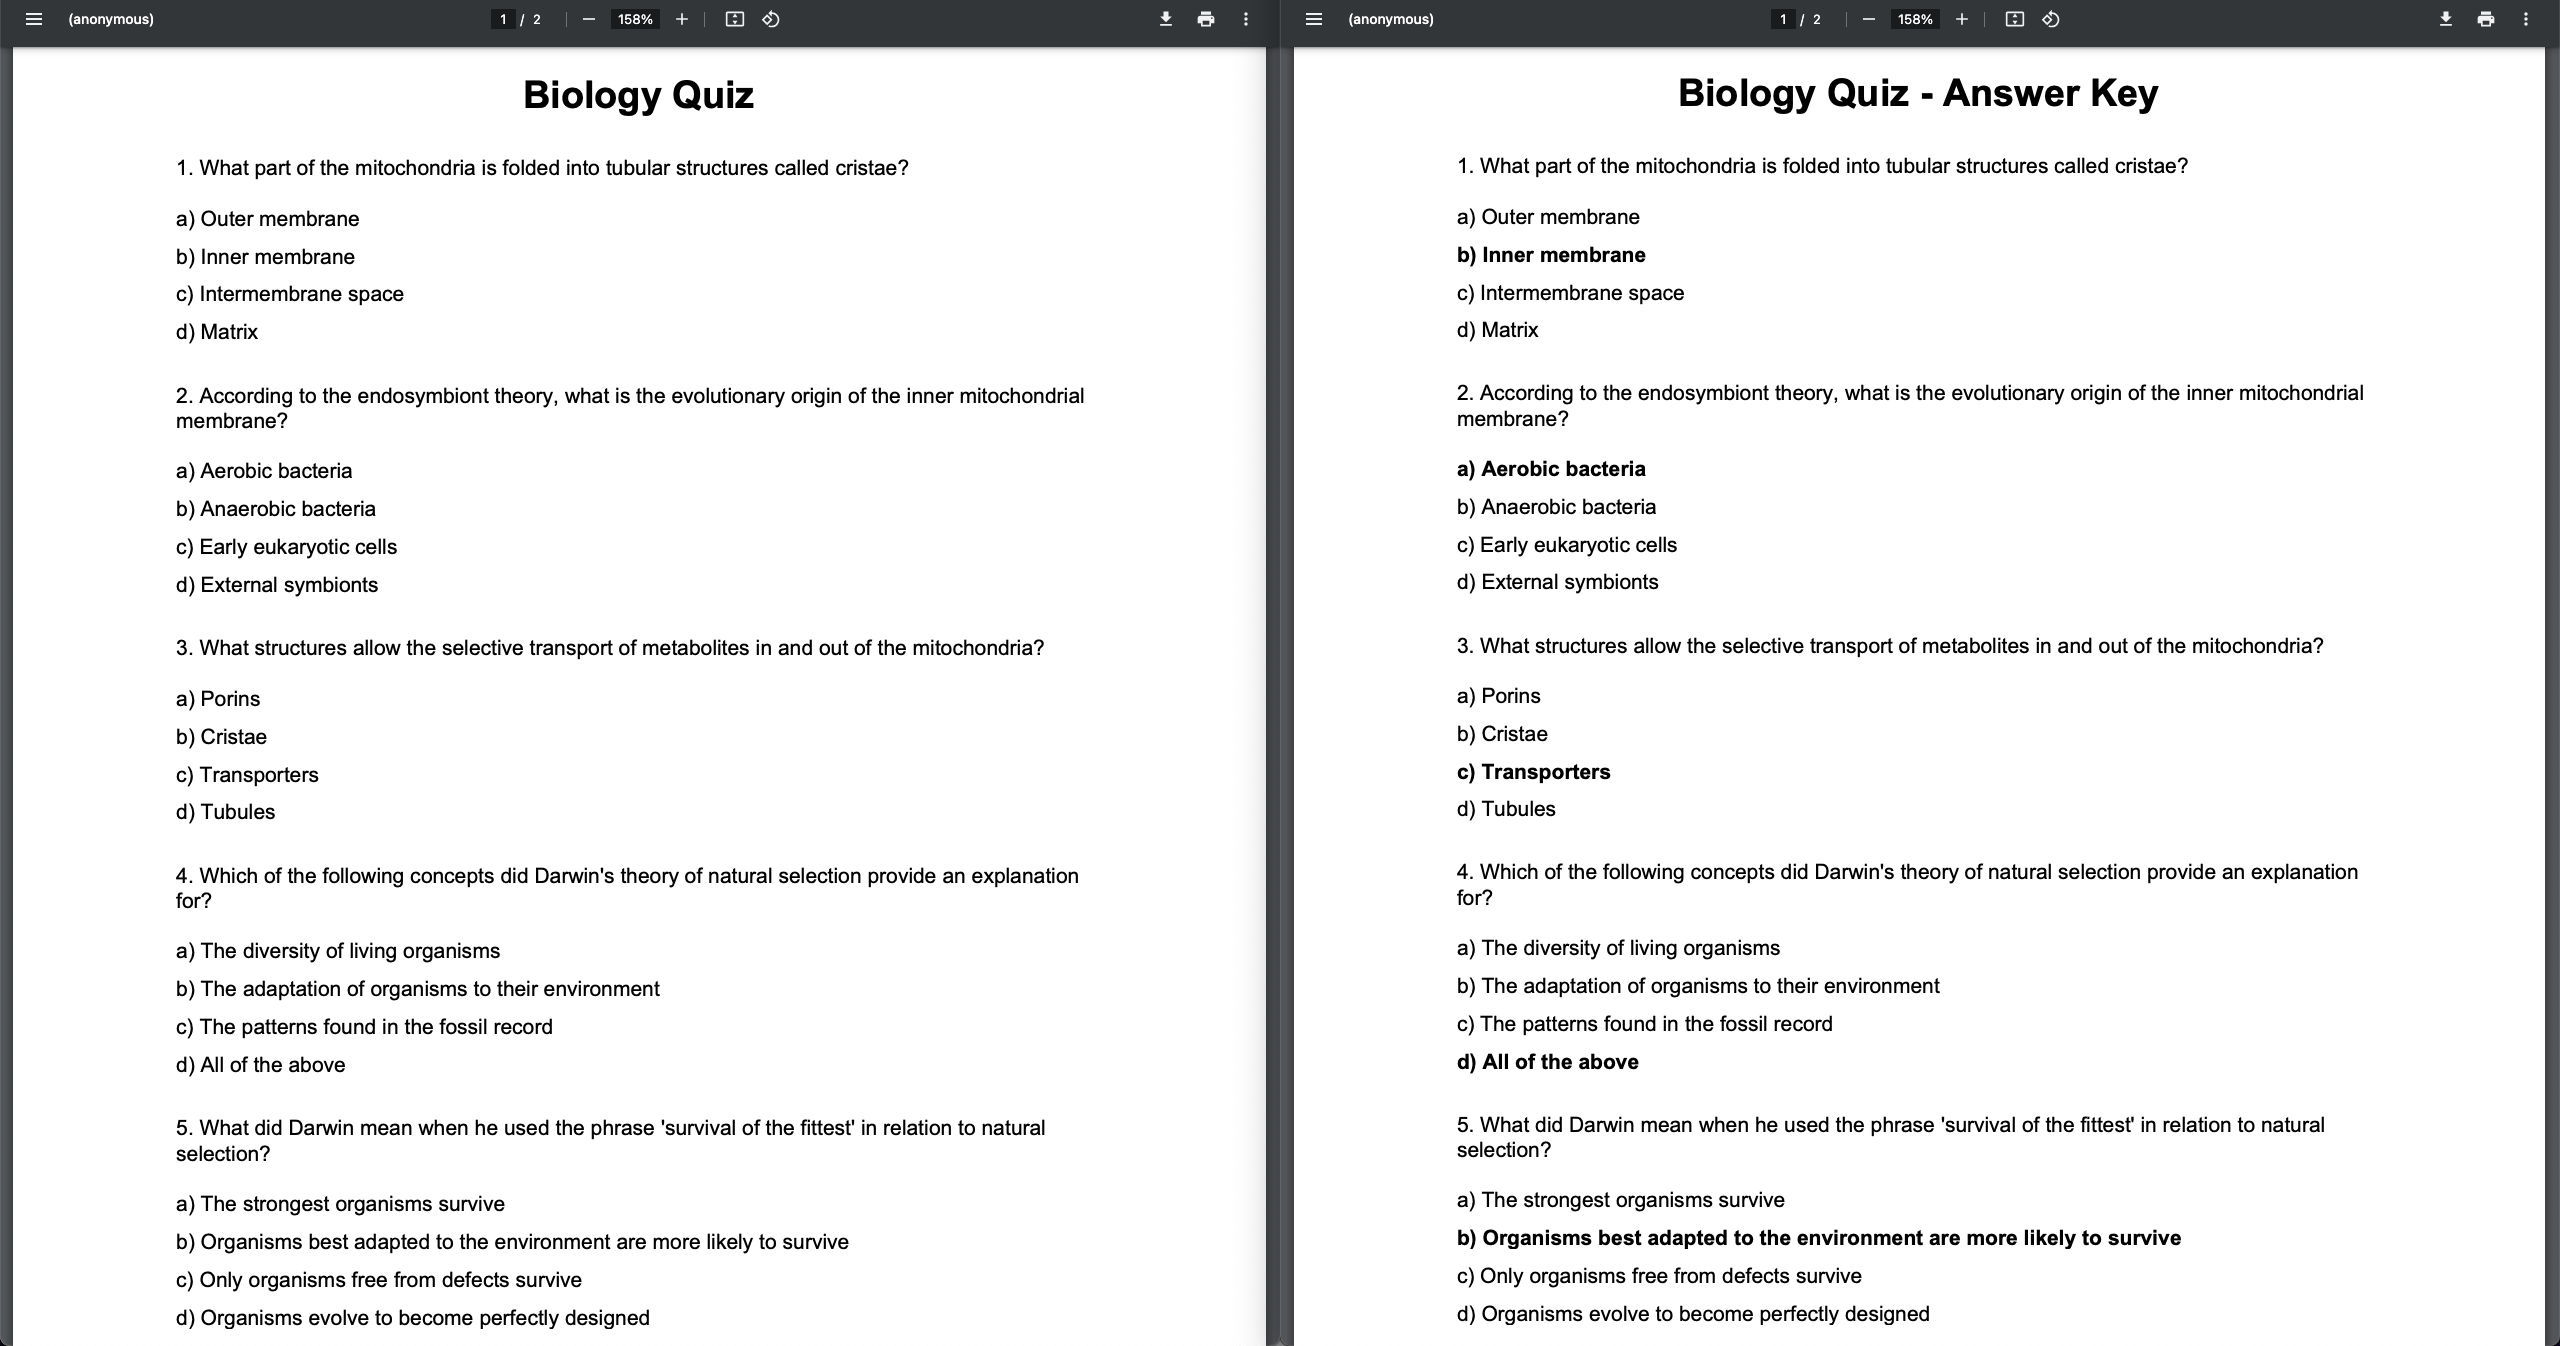

In [145]:
Image(filename=('./bio_quiz_screenshot.png'))